In [1]:
# Carrie Lei & Diana Cantini
# Final Project: Phased Array Antenna Simulation

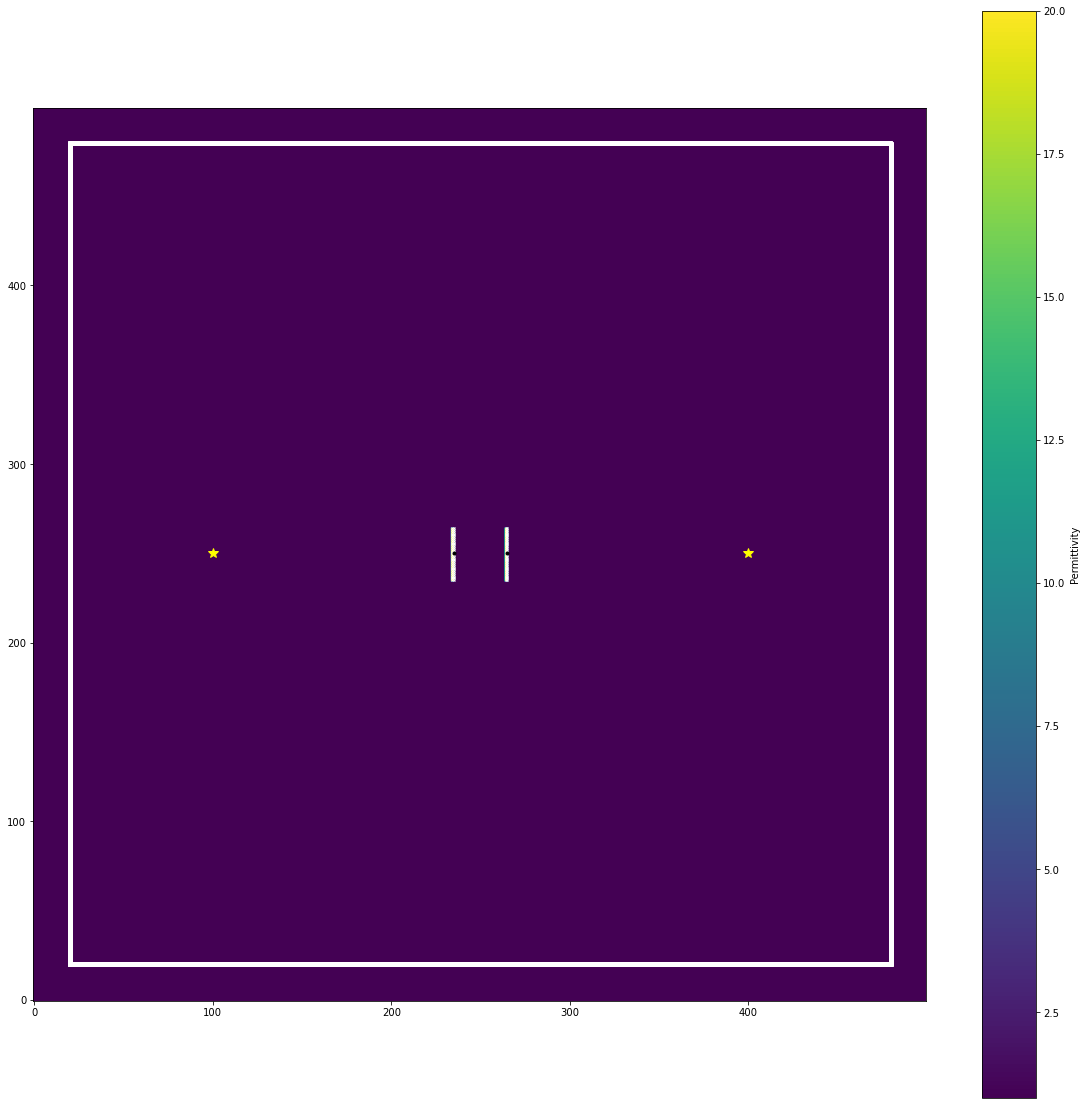

In [31]:
# streamlined function to simulate 1xn antennas

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

# Simulation Parameters
e0 = 1        
mu0 = 1       
c0 = 1  # 1 / math.sqrt(e0 * mu0) 
dx = 0.5e-3  # unit cell is 0.5mm x 0.5mm
dy = 0.5e-3 
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 500

# Grid in cell units
whole_grid = 250e-3  # whole grid = 200 mm
numX_cells = int(whole_grid / dx)  
numY_cells = int(whole_grid / dy)   
center_x = numX_cells // 2  # find center points
center_y = numY_cells // 2

# Set up the permittivity grid 
grid = np.ones((numY_cells, numX_cells)) * e0

# Source parameters
lambda0 = 0.06  # 6 cm wavelength for 5 GHz
lambda_lower = c0 / 4.5e-9
lambda_upper = c0 / 5.5e-9
omega0 = 2 * np.pi * c0 / lambda0
sigma = (2 / omega0) * (lambda0 / (lambda_upper - lambda_lower))

# Arrays to store fields
Ez = np.zeros((numX_cells, numY_cells))
Hx = np.zeros((numX_cells, numY_cells))
Hy = np.zeros((numX_cells, numY_cells))

# Dipole Parameters
numberAntennas = 2
dipole_epsilon = 20
dipole_spacing_cells = int(.015 / dx)  # space between dipoles = lambda/4 = 1.5cm
dipole_width = 1e-3  # dipole thickness = 1 mm
dipole_height = 15e-3  # dipole height = 15 mm
dipole_width_cells = int(dipole_width / dx)         
dipole_height_cells = int(dipole_height / dy)  

# Probe locations
probe_beam_direction_x = int(numX_cells *.8)
probe_beam_direction_y = int(numY_cells * .5)
probe_x = int(numX_cells * .2)
probe_y = int(numY_cells *.5)
Ez_probe_beam = np.zeros(max_time_steps) 
Ez_probe = np.zeros(max_time_steps)


# NTFF Parameters ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Compute phasor E and M fields on closed contour boundary
# defining square boundary form L1 --> L4
line_size = whole_grid - 20e-3 # lines form a boundary 10mm inside of whole grid size
numL_cells = int(line_size // dx) #numL cells is length of closed countour boundary in cell units

L_starting_dim= 10e-3 #starting index for L2, L4
L_starting_cell_idx = int(L_starting_dim //dx)
L_ending_dim= numX_cells - numL_cells
L_ending_cell_idx=L_starting_cell_idx + numL_cells

#L1 is vertical, RHS line
L1_col1 = np.full(numL_cells, L_ending_cell_idx)
L1_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)

L1_idxs = np.column_stack((L1_col1,L1_col2))

#L2 is vertical, LHS line
L2_col1=np.full(numL_cells,L_starting_cell_idx)
L2_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L2_idxs=np.column_stack((L2_col1,L2_col2))

#L3 is horizontal, top line
L3_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L3_col2=np.full(numL_cells, L_ending_cell_idx)
L3_idxs=np.column_stack((L3_col1,L3_col2))

#L4 is horizontal, bottom line
L4_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L4_col2=np.full(numL_cells, L_starting_cell_idx)
L4_idxs=np.column_stack((L4_col1,L4_col2))

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Current source vectors
sources = []

# Beam steering parameters
angle_target = 0
angle_target_rad = np.deg2rad(angle_target)

# Store Ez Frames
Ez_frames = []

def placeAndVisualizeAntennas(numAntennas, spacingBetween, dipoleLength, dipoleWidth, grid, e_dipole):

    # find where the centers of each dipole would be
    centers = []

    if (numAntennas %2) == 1:  # odd number: middle antenna at center
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2) * spacingBetween
            centers.append(leftPoint + (i * spacingBetween))
    else:  # even number: center is between two
        spaceFromCenter = spacingBetween // 2
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2 - 1) * spacingBetween - spaceFromCenter
            centers.append(leftPoint + (i * spacingBetween))

    # Visualize everything
    plt.figure(figsize=(20, 20))

    for x in centers:
        x_center = x
        x_left = x_center - (dipoleWidth // 2)
        x_right = x_left + dipoleWidth - 1
        x_bottom = center_y - (dipoleLength // 2)
        x_top = x_bottom + dipoleLength - 1

        # place antennas on permittivity grid
        for y in range(x_left, x_right + 1):
            for z in range(x_bottom, x_top + 1):
                grid[z,y] = e_dipole
                plt.plot(y, z, 'x', markersize = 2, color='white')

        sources.append((x, center_y))

    # Show sources and probes
    for location in sources:
        plt.plot(location[0], location[1], 'o', markersize = 3, color = 'black')

    plt.plot(probe_beam_direction_x, probe_beam_direction_y, '*', markersize = 10, color = 'yellow')
    plt.plot(probe_x, probe_y, '*', markersize = 10, color = 'yellow')

    # Add NTFF boundary markers
    all_line_idx = [L1_idxs, L2_idxs, L3_idxs, L4_idxs]
    for j in all_line_idx:
        for x, y in j:
            plt.plot(x, y, 's', markersize = 4, color = 'white')

    # Plot grid
    plt.imshow(grid, cmap='viridis', origin='lower')
    plt.colorbar(label='Permittivity')

    # Legend
    plt.plot([], [], 'x', color='white', label='Dipole')
    plt.plot([], [], 'o', color='black', label='Current Source')
    plt.plot([], [], '*', color='yellow', label='Probe')
    plt.plot([], [], 's', color='white', label='NTFF Contour Boundary')


placeAndVisualizeAntennas(numberAntennas, dipole_spacing_cells, dipole_height_cells, dipole_width_cells, grid, dipole_epsilon)

In [32]:
# Calculate phase shifts for each antenna element

k0 = 2 * np.pi / lambda0
angle_target = 30
angle_target_rad = np.deg2rad(angle_target)

kx = k0 * np.cos(angle_target_rad)
ky = k0 * np.sin(angle_target_rad)

for x_coord, y_coord in sources:
    x_pos = (x_coord - center_x) * dx
    y_pos = (y_coord - center_y) * dy
    phase = (kx * x_pos + ky * y_pos)
    print(x_coord, y_coord, phase)

235 250 -0.6801747615878317
265 250 0.6801747615878317


In [33]:
# Defining Ez_time_L1 (right hand side line)
Ez_time_L1 = np.zeros((numL_cells, max_time_steps))
Hx_time_L1 = np.zeros((numL_cells, max_time_steps))
Hy_time_L1 = np.zeros((numL_cells, max_time_steps))

# defining L2
Ez_time_L2 = np.zeros((numL_cells, max_time_steps))
Hx_time_L2 = np.zeros((numL_cells, max_time_steps))
Hy_time_L2 = np.zeros((numL_cells, max_time_steps))

# defining L3
Ez_time_L3 = np.zeros((numL_cells, max_time_steps))
Hx_time_L3 = np.zeros((numL_cells, max_time_steps))
Hy_time_L3 = np.zeros((numL_cells, max_time_steps))

# defining L4
Ez_time_L4 = np.zeros((numL_cells, max_time_steps))
Hx_time_L4 = np.zeros((numL_cells, max_time_steps))
Hy_time_L4 = np.zeros((numL_cells, max_time_steps))

# combining into more streamlined list so can process easier later
L_idxs_list = [L1_idxs, L2_idxs, L3_idxs, L4_idxs]
Ez_time_list = [Ez_time_L1, Ez_time_L2, Ez_time_L3, Ez_time_L4]
Hx_time_list = [Hx_time_L1, Hx_time_L2, Hx_time_L3, Hx_time_L4]
Hy_time_list = [Hy_time_L1, Hy_time_L2, Hy_time_L3, Hy_time_L4]

NTFF_lines = []
for Ez_time, Hx_time, Hy_time, idxs in zip(Ez_time_list, Hx_time_list, Hy_time_list, L_idxs_list):
    mask = np.zeros((numX_cells, numY_cells), dtype=bool)
    index_map = -np.ones((numX_cells, numY_cells), dtype=int)
    
    for idx, (x, y) in enumerate(idxs):
        mask[x, y] = True
        index_map[x, y] = idx
    
    NTFF_lines.append({"Ez": Ez_time, "Hx": Hx_time, "Hy": Hy_time, "mask": mask, "index": index_map})

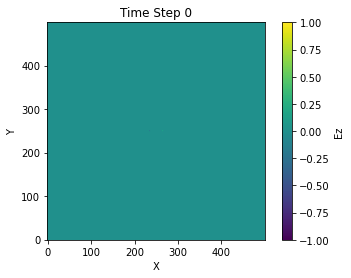

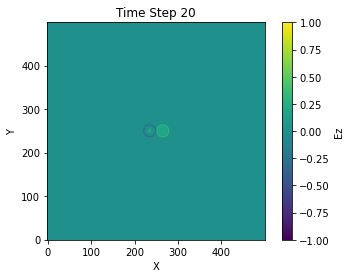

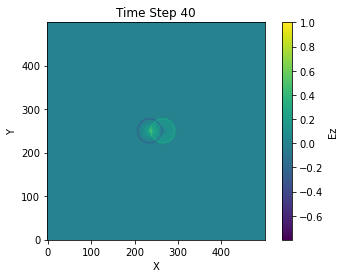

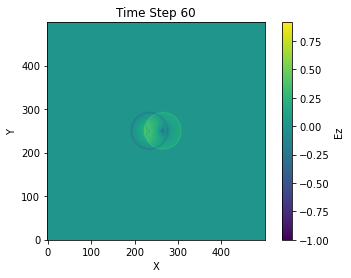

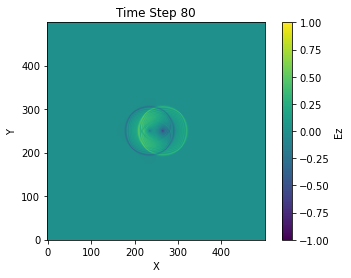

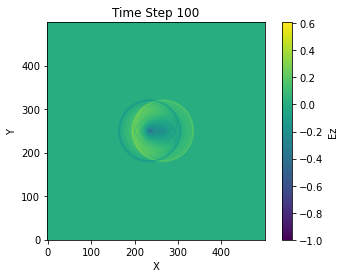

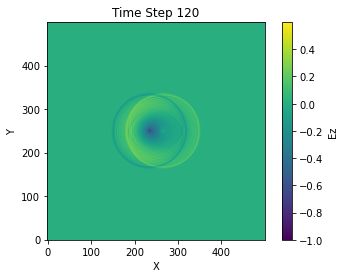

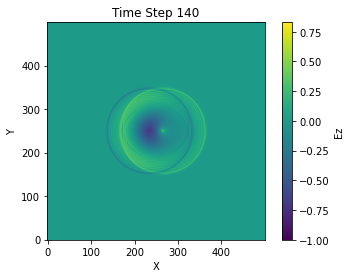

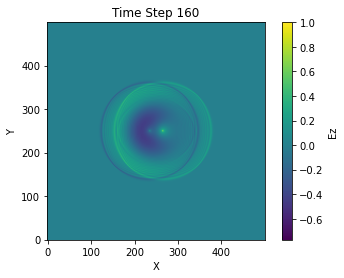

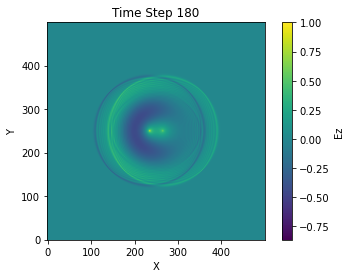

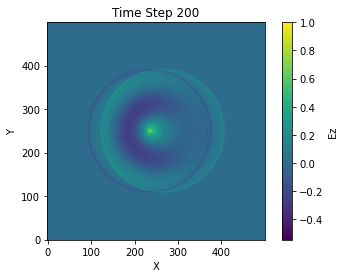

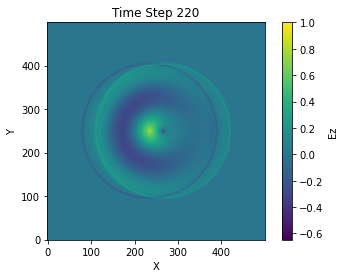

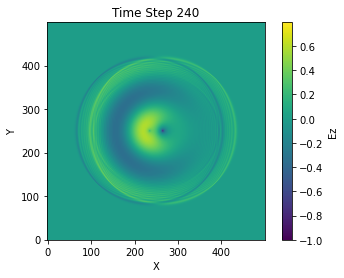

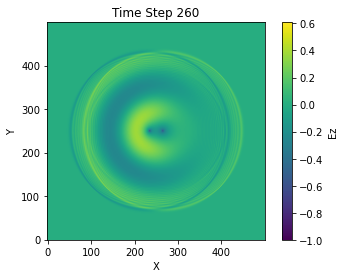

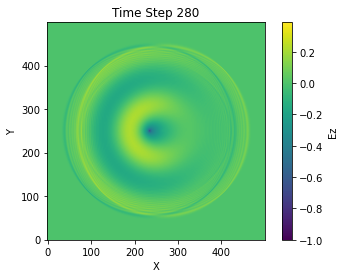

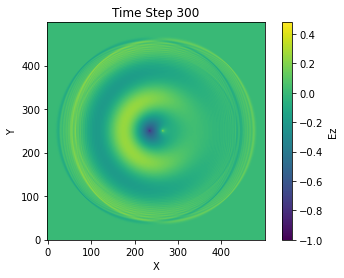

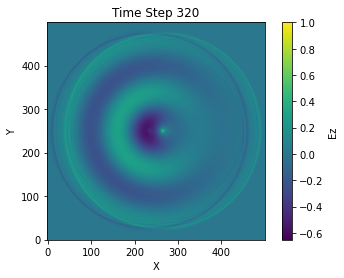

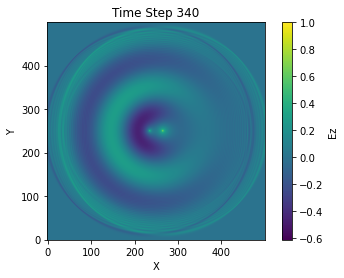

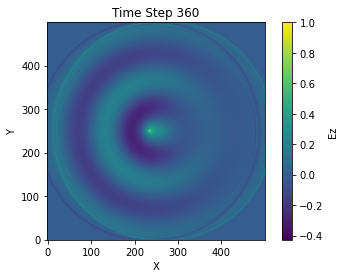

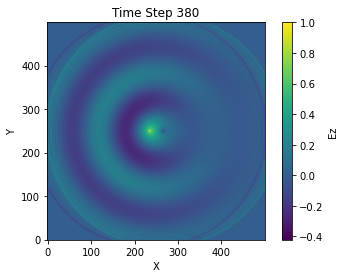

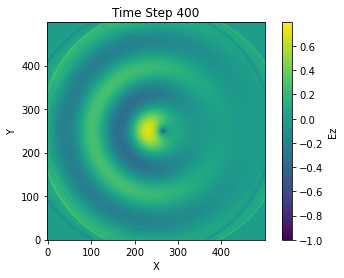

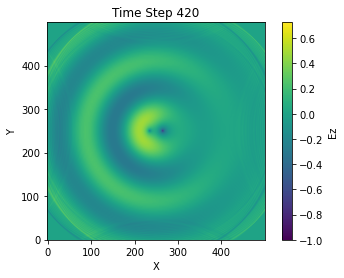

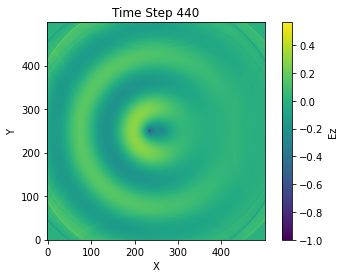

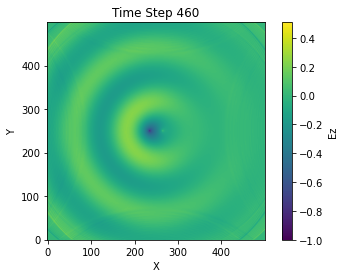

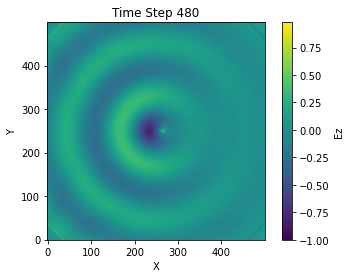

In [ ]:
# Main 2D FDTD Loop

#Initializing very first boundaries
boundaryLeft = 0
boundaryBottom = 0
boundaryRight = 0
boundaryTop = 0
    
for n in range(max_time_steps):

    # Compute Hy 
    for i in range(numX_cells - 1):
        for j in range(numY_cells):
            Hy[i, j] += (Ez[i + 1, j] - Ez[i, j]) * magic_time_step / dx

            for line in NTFF_lines:
                if line["mask"][i, j]:
                    idx = line["index"][i, j]
                    # line["Hy"][idx, n] = 0.5 * (Hy[i, j] + Hy[i - 1, j])  # collocation
                    line["Hy"][idx, n] = Hy[i, j]
    # Compute Hx
    for i in range(numX_cells):
        for j in range(numY_cells - 1):
            Hx[i, j] -= (Ez[i, j + 1] - Ez[i, j]) * magic_time_step / dy
            
            for line in NTFF_lines:
                if line["mask"][i, j]:
                    idx = line["index"][i, j]
                    # line["Hx"][idx, n] = 0.5 * (Hx[i, j] + Hx[i, j - 1])  # collocation
                    line["Hx"][idx, n] = Hx[i, j]


    # Use temp variables to store left and bottom Ez values sorta like a moving window; only 2 sides needed bc symmetrical
    tempLeft = Ez[1, :].copy() 
    tempBottom = Ez[:, 1].copy()  

    # Compute Ez 
    for i in range(1, numX_cells - 1):
        for j in range(1, numY_cells - 1):
            Ez[i, j] += (1 / grid[i, j]) * ((Hy[i, j] - Hy[i - 1, j]) * magic_time_step / dx) - ((Hx[i, j] - Hx[i, j - 1]) * magic_time_step / dy)

            #recording Ez at Lines
            for line in NTFF_lines:
                if line["mask"][i, j]:
                    idx = line["index"][i, j]
                    line["Ez"][idx, n] = Ez[i, j]
                    
    # Store Ez at probes
    Ez_probe_beam[n] = np.abs(Ez[probe_beam_direction_x, probe_beam_direction_y])
    Ez_probe[n] = np.abs(Ez[probe_x, probe_y])

    # Apply excitation at antenna sources
    t_n = n * magic_time_step
    for location in sources:
        x_pos = (location[0]- center_x) * dx
        y_pos = (location[1] - center_y) * dy
        phase = (kx * x_pos + ky * y_pos)
        Ez[location[0], location[1]] += 25*np.sin(omega0 * t_n + phase)

    # Update absorbing conditions
    Ez[0, :] = boundaryLeft
    Ez[-1, :] = boundaryRight
    Ez[:, 0] = boundaryBottom
    Ez[:, -1] = boundaryTop

    # Update boundary buffers for next time step
    boundaryLeft = tempLeft
    boundaryBottom = tempBottom
    boundaryRight = Ez[-2, :].copy()
    boundaryTop = Ez[:, -2].copy()
    
    # Visualize Ez field every 50 time steps
    if n % 20 == 0:
        plt.clf() 
        plt.imshow(Ez.T / np.max(np.abs(Ez)), cmap='viridis', origin='lower')
        plt.title(f"Time Step {n}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar(label="Ez")
        plt.pause(0.01) 
        plt.show()
    
    # Create Ez animation using frames at every 10 time steps 
    if n % 10 == 0:
        Ez_frames.append(Ez.copy())


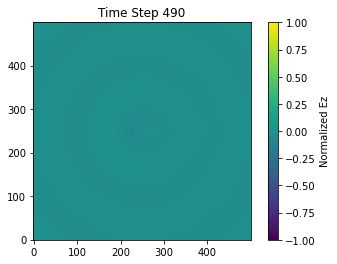

In [ ]:
# Create animation in output to visualize
from IPython.display import HTML
import matplotlib.animation as animation

# Compute global max for normalization
max_val = max(np.max(np.abs(frame)) for frame in Ez_frames)

fig, ax = plt.subplots()
cax = ax.imshow(Ez_frames[0].T / max_val, cmap='viridis', origin='lower')
fig.colorbar(cax, label="Normalized Ez")
title = ax.set_title("")

def update(frame_idx):
    normalized_frame = Ez_frames[frame_idx].T / max_val
    cax.set_array(normalized_frame)
    title.set_text(f"Time Step {frame_idx * 10}")
    return cax, title

ani = animation.FuncAnimation(fig, update, frames=len(Ez_frames), interval=100, blit=False)
HTML(ani.to_jshtml())

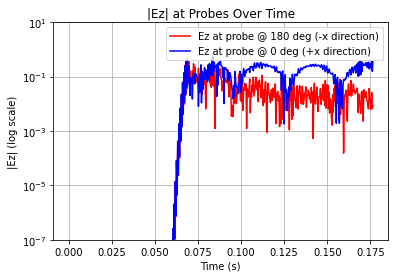

In [36]:
# Plot Ez at the probe in direction of beam over time in comparison to probe at opposite direction
time_steps = np.arange(max_time_steps)*magic_time_step
plt.semilogy(time_steps, Ez_probe_beam, label='Ez at probe @ 180 deg (-x direction)', color = 'red')
plt.semilogy(time_steps, Ez_probe, label='Ez at probe @ 0 deg (+x direction)', color = 'blue')
plt.xlabel('Time (s)')
plt.ylabel('|Ez| (log scale)')
plt.title('|Ez| at Probes Over Time')
plt.ylim(10e-8, 1e1)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# NTFF Transformation 

# Performing FFT along closed contours
Ez_fft_vals = [np.fft.fft(Ez_time, axis=1) for Ez_time in Ez_time_list]
Ez_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Ez_time_list]

Hx_fft_vals = [np.fft.fft(Hx_time, axis=1) for Hx_time in Hx_time_list]
Hx_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Hx_time_list]

Hy_fft_vals = [np.fft.fft(Hy_time, axis=1) for Hy_time in Hy_time_list]
Hy_freqs = [np.fft.fftfreq(max_time_steps, d=magic_time_step) for _ in Hy_time_list]

peak_freq_val=16.970562748477143

# Computing equivalent J and M current densities
for freqs_arr in Ez_freqs:
    target_freq= omega0/(2*np.pi)
    bin_idx = np.argmin(np.abs(freqs_arr - target_freq))
    print('Bin index is ',bin_idx)

print('target_freq = ',target_freq)
Meq_L1_phasors = Ez_fft_vals[0][:,bin_idx]
Meq_L2_phasors = -Ez_fft_vals[1][:,bin_idx]
Meq_L3_phasors = -Ez_fft_vals[2][:,bin_idx]
Meq_L4_phasors= Ez_fft_vals[3][:,bin_idx]

Jeq_L1_phasors=Hy_fft_vals[0][:,bin_idx]
Jeq_L2_phasors=-Hy_fft_vals[1][:,bin_idx]
Jeq_L3_phasors=-Hx_fft_vals[2][:,bin_idx]
Jeq_L4_phasors=Hx_fft_vals[3][:,bin_idx]

#creating list for all Jeq and Meq components along grid
Meq_phasors=[Meq_L1_phasors,Meq_L2_phasors,Meq_L3_phasors,Meq_L4_phasors]
Jeq_phasors=[Jeq_L1_phasors,Jeq_L2_phasors,Jeq_L3_phasors,Jeq_L4_phasors]

#Computing r' cos (phi) for each exponential factor in scattering width eqn
#Nested loop to compute each individual line integral component, for each theta
#Computing scattering width for each theta component
theta_input_param=np.linspace(1,360,360)
r_prime_cos_phi_vec=[]
sigma_2d=np.zeros(360)

#replace lambda0 with lambda
lambda_new=c0/peak_freq_val
k = 2 * np.pi / lambda_new
E_initial_amplitude = 1
for theta in theta_input_param:
    theta_deg = theta
    r_prime_cos_phi_vec_L1=[]
    r_prime_vec_L1=[]
    phi_vector_L1=[]

    theta_rad=math.radians(theta_deg)
    r_mag_L1=((L_ending_cell_idx-center_x)*dx) / math.cos(theta_rad)
    for x, y in L1_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=np.linalg.norm(x_y_distances)
        
        theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=theta_deg-theta_prime_deg

        phi_rad=math.radians(phi)
        phi_vector_L1.append(phi)

        phase_const= r_mag_L1 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L1.append(phase_const)
    
    r_prime_cos_phi_vec_L2=[]
    r_prime_vec_L2=[]
    phi_vector_L2=[]
    r_mag_L2=abs(((L_starting_cell_idx-center_x)*dx)) / math.cos(theta_rad)

    for x, y in L2_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.asin ( ((y-center_y)*dy) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=-((theta_deg-180)-theta_prime_deg)

        phi_rad=math.radians(phi)
        phi_vector_L2.append(phi)

        phase_const= r_mag_L2 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L2.append(phase_const)

    r_prime_cos_phi_vec_L3=[]
    r_prime_vec_L3=[]
    phi_vector_L3=[]
    r_mag_L3=abs(((L_ending_cell_idx-center_y*dy) / math.sin(theta_rad)))

    for x, y in L3_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.acos ( ((x-center_x)*dx) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=(180-theta_deg)-theta_prime_deg

        phi_rad=math.radians(phi)
        phi_vector_L3.append(phi)

        phase_const= r_mag_L3 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L3.append(phase_const)

    r_prime_cos_phi_vec_L4=[]
    r_prime_vec_L4=[]
    phi_vector_L4=[]
    r_mag_L4=abs(((L_starting_cell_idx-center_y*dy) / math.sin(theta_rad)))

    for x, y in L4_idxs:
        x_y_distances=np.array([(x-center_x)*dx,(y-center_y)*dy])
        r_prime_mag=abs(np.linalg.norm(x_y_distances))
        
        theta_prime_rad = math.acos ( ((x-center_x)*dx) / r_prime_mag)
        theta_prime_deg=math.degrees(theta_prime_rad)
        phi=-((theta_deg-180)-theta_prime_deg)

        phi_rad=math.radians(phi)
        phi_vector_L4.append(phi)

        phase_const= r_mag_L4 * math.cos(phi_rad)

        r_prime_cos_phi_vec_L4.append(phase_const)

    r_cos_factors=[r_prime_cos_phi_vec_L1,r_prime_cos_phi_vec_L2,r_prime_cos_phi_vec_L3,r_prime_cos_phi_vec_L4]
    r_cos_factors=np.array(r_cos_factors)


    L_integral_arr=[ ((omega0*mu0*np.sum(Jeq[0:-1])) - (k*Meq[0:-1]))*np.exp(1j*k*r_cos[0:-1])
                for Jeq, Meq, r_cos in zip(Jeq_phasors,Meq_phasors, r_cos_factors)]
    
   
    L_integral_vals=[ (np.sum(contour_val)) for contour_val in L_integral_arr]
   
    L_integral_final=(abs(np.sum(L_integral_vals)))**2
    sigma_2d[int(theta) - 1]=(lambda_new / (8*np.pi*(E_initial_amplitude**2))) * L_integral_final

Bin index is  3
Bin index is  3
Bin index is  3
Bin index is  3
target_freq =  16.666666666666668


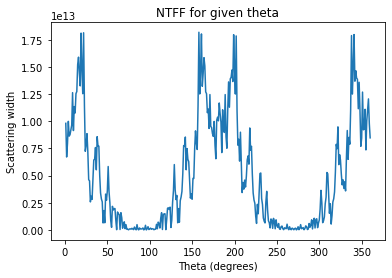

In [38]:
#Plotting Scattering width, linear
 
plt.figure()
plt.plot(theta_input_param, sigma_2d)
plt.xlabel('Theta (degrees)')
plt.ylabel('Scattering width')
plt.title('NTFF for given theta')
plt.show()

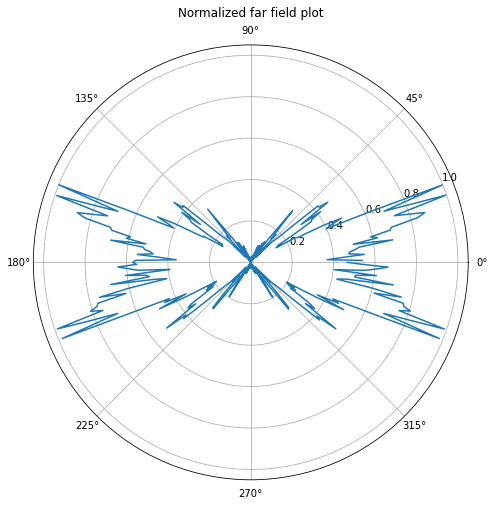

In [ ]:
# Polar plot
# thetas = np.linspace(-90, 90, numY_cells)
theta_rad = np.radians(theta_input_param) # theta already in degrees
r_normalized = np.abs(sigma_2d)/np.max(np.abs(sigma_2d))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.plot(theta_rad, r_normalized)
ax.set_title('Normalized far field plot', va='bottom')
plt.show()